In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


In [6]:
df1 = pd.read_csv('csvs/AutoSleep-20200124-to-20221231.csv')
df2 = pd.read_csv('csvs/AutoSleep-20230101-to-20240801.csv')

# Convert 'fromDate' to datetime
# df1['fromDate'] = pd.to_datetime(df1['fromDate'])
# df2['fromDate'] = pd.to_datetime(df2['fromDate'])

# Filter out rows from df2 that are already in df1
df2 = df2[~df2['fromDate'].isin(df1['fromDate'])]

# Concatenate the DataFrames
df = pd.concat([df1, df2])

In [7]:
df = df.drop(['fellAsleepIn', 'SpO2Avg', 'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax',
              'tags', 'notes', 'asleepAvg7','efficiencyAvg7', 'qualityAvg7', 'deepAvg7', 'sleepBPMAvg7', 
              'dayBPMAvg7', 'wakingBPMAvg7', 'hrvAvg7','sleepHRVAvg7'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 498
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ISO8601     1395 non-null   object 
 1   fromDate    1395 non-null   object 
 2   toDate      1395 non-null   object 
 3   bedtime     1395 non-null   object 
 4   waketime    1395 non-null   object 
 5   inBed       1395 non-null   object 
 6   awake       1395 non-null   object 
 7   sessions    1395 non-null   int64  
 8   asleep      1395 non-null   object 
 9   efficiency  1395 non-null   float64
 10  quality     1394 non-null   object 
 11  deep        1394 non-null   object 
 12  sleepBPM    1394 non-null   float64
 13  dayBPM      1223 non-null   float64
 14  wakingBPM   1393 non-null   float64
 15  hrv         1392 non-null   float64
 16  sleepHRV    1388 non-null   float64
dtypes: float64(6), int64(1), object(10)
memory usage: 196.2+ KB


In [8]:
# Datetime conversions
df['ISO8601'] = pd.to_datetime(df['ISO8601'])
df['fromDate'] = pd.to_datetime(df['fromDate'], format='%A, %b %d, %Y')
df['toDate'] = pd.to_datetime(df['toDate'], format='%A, %b %d, %Y')
df['bedtime'] = pd.to_datetime(df['bedtime']).dt.time
df['waketime'] = pd.to_datetime(df['waketime']).dt.time

df['inBed'] = pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.hour + (pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.minute / 60)
df['awake'] = pd.to_datetime(df['awake'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['awake'], format='%H:%M:%S').dt.minute / 60)
df['asleep'] = pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.minute / 60)
df['quality'] = pd.to_datetime(df['quality'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['quality'], format='%H:%M:%S').dt.minute / 60)
df['deep'] = pd.to_datetime(df['deep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['deep'], format='%H:%M:%S').dt.minute / 60)


In [9]:
# Count how many days since the date of the first record in df until today
daysPassed = (df['fromDate'].max() - df['fromDate'].min()).days

# Find the percentage of days tracked
percentage_tracked = round((len(df) / daysPassed) * 100,2)

from datetime import datetime
from dateutil.relativedelta import relativedelta

timeElapsed = relativedelta(df['fromDate'].max(), df['fromDate'].min())
timeElapsed = f"{timeElapsed.years} years, {timeElapsed.months} months, {timeElapsed.days} days"

monthsMissed = (daysPassed - len(df)) // 30
daysMissed = (daysPassed - len(df)) % 30

print(f"Percentage of days tracked: {percentage_tracked}%")
print(f'Time Elapsed: {timeElapsed}')
print(f'Time Missed: {monthsMissed} months, {daysMissed} days')


Percentage of days tracked: 84.49%
Time Elapsed: 4 years, 6 months, 8 days
Time Missed: 8 months, 16 days


In [45]:
most_common_bedtime = df['bedtime'].mode()[0]
most_common_waketime = df['waketime'].mode()[0]

count_bedtime = df['bedtime'].value_counts().max()
count_waketime = df['waketime'].value_counts().max()

print(f"Most common bedtime: {most_common_bedtime} (Count: {count_bedtime})")
print(f"Most common waketime: {most_common_waketime} (Count: {count_waketime})")


Most common bedtime: 00:45:00 (Count: 36)
Most common waketime: 10:30:00 (Count: 23)


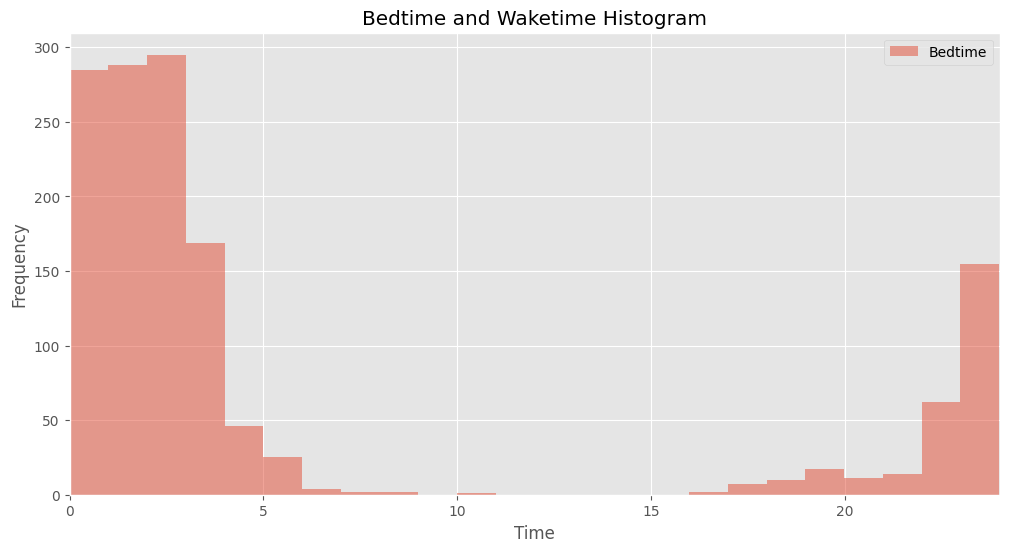

In [37]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df['bedtime'].apply(lambda x: x.hour + x.minute/60), bins=24, alpha=0.5, label='Bedtime')
ax.legend(loc='upper right')
ax.set_title('Bedtime and Waketime Histogram')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 24)

plt.show()


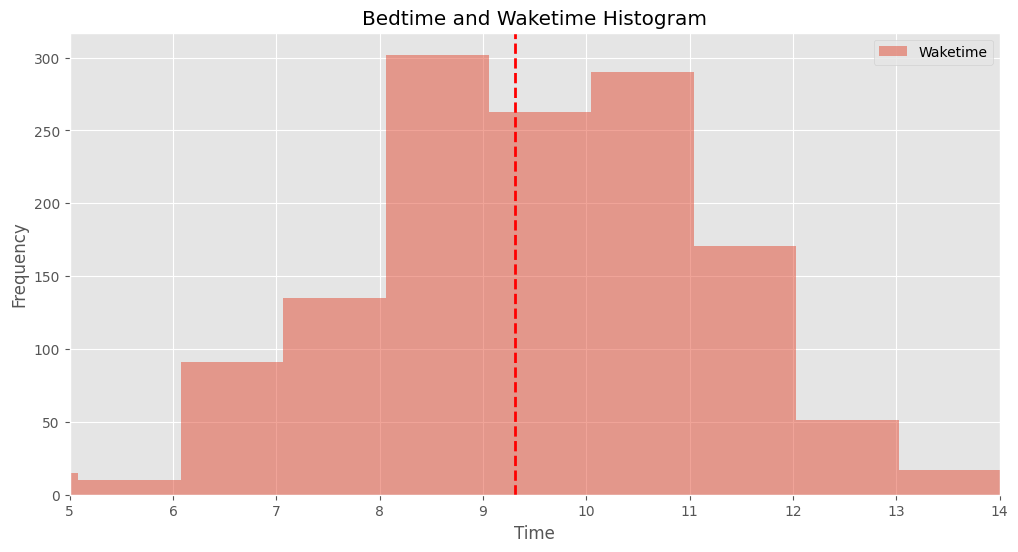

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df['waketime'].apply(lambda x: x.hour + x.minute/60), bins=24, alpha=0.5, label='Waketime')
ax.axvline(df['waketime'].apply(lambda x: x.hour + x.minute/60).mean(), color='r', linestyle='dashed', linewidth=2)
ax.legend(loc='upper right')
ax.set_title('Bedtime and Waketime Histogram')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_xlim(5, 14)

plt.show()


In [10]:
# Rolling values
cols_to_roll = ['asleep', 'quality', 'deep', 'efficiency', 'sleepBPM', 'wakingBPM', 'hrv', 'sleepHRV']
periods = [7,15,30,90]

for col in cols_to_roll:
    for period in periods:
        df[f'{col}Roll{period}'] = df[col].rolling(window=period).mean()


In [11]:
df['qual/asleep'] = df['quality'] / df['asleep']
df['deep/asleep'] = df['deep'] / df['asleep']

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
inBed,1395.0,8.046846,1.485853,0.600000,7.233333,7.983333,8.800000,23.583333
awake,1395.0,0.802437,0.794638,0.000000,0.216667,0.583333,1.150000,5.316667
sessions,1395.0,1.029391,0.173153,1.000000,1.000000,1.000000,1.000000,3.000000
asleep,1395.0,7.244409,1.418243,0.500000,6.416667,7.283333,8.066667,21.966667
efficiency,1395.0,90.245878,9.168629,22.900000,85.600000,92.700000,97.350000,100.000000
quality,1394.0,5.110868,1.141202,0.166667,4.416667,5.133333,5.850000,14.716667
deep,1394.0,1.831241,1.008708,0.000000,1.233333,1.866667,2.512500,6.733333
sleepBPM,1394.0,55.114132,7.940234,42.000000,49.800000,52.800000,57.900000,103.100000
dayBPM,1223.0,69.081684,9.934766,45.800000,62.050000,69.000000,75.500000,102.800000
wakingBPM,1393.0,50.547308,6.280389,36.000000,47.000000,49.000000,53.000000,117.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 498
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ISO8601           1395 non-null   object        
 1   fromDate          1395 non-null   datetime64[ns]
 2   toDate            1395 non-null   datetime64[ns]
 3   bedtime           1395 non-null   object        
 4   waketime          1395 non-null   object        
 5   inBed             1395 non-null   float64       
 6   awake             1395 non-null   float64       
 7   sessions          1395 non-null   int64         
 8   asleep            1395 non-null   float64       
 9   efficiency        1395 non-null   float64       
 10  quality           1394 non-null   float64       
 11  deep              1394 non-null   float64       
 12  sleepBPM          1394 non-null   float64       
 13  dayBPM            1223 non-null   float64       
 14  wakingBPM         1393 no

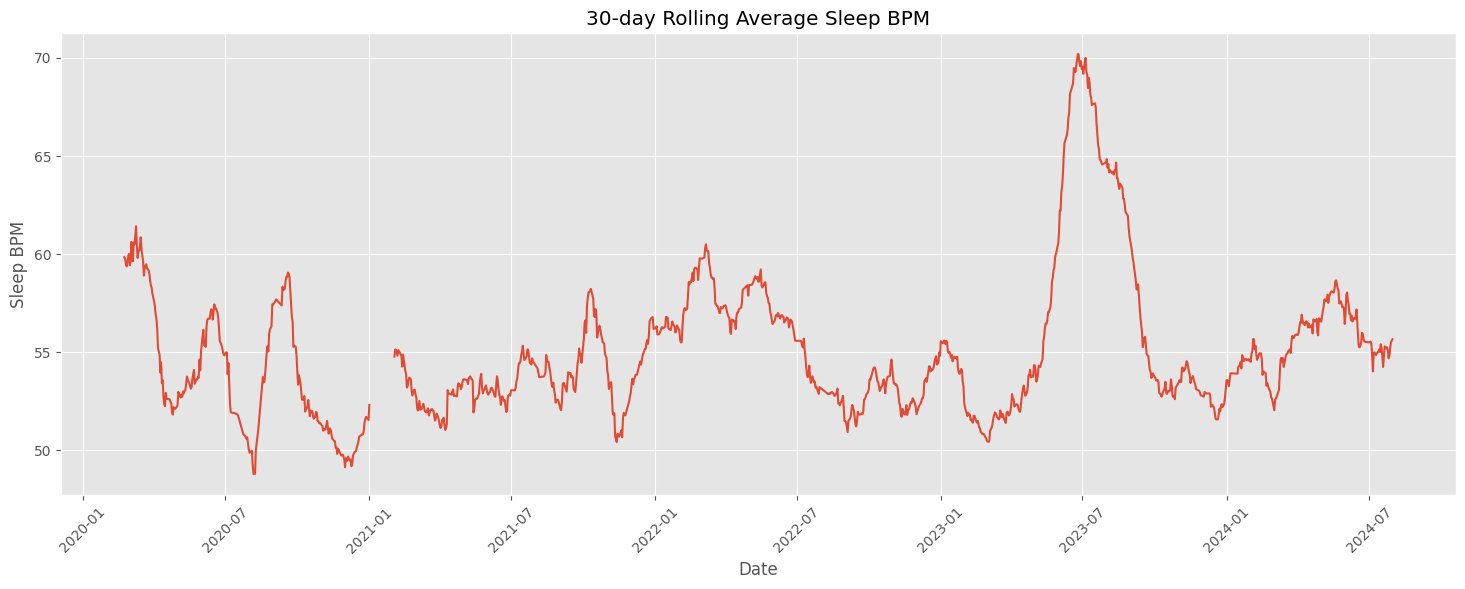

In [14]:
period = 30

plt.figure(figsize=(18,6))
plt.plot(df['fromDate'], df[f'sleepBPMRoll{period}'])
plt.title(f'{period}-day Rolling Average Sleep BPM')
plt.xlabel('Date')
plt.ylabel('Sleep BPM')
plt.xticks(rotation=45)
plt.show()


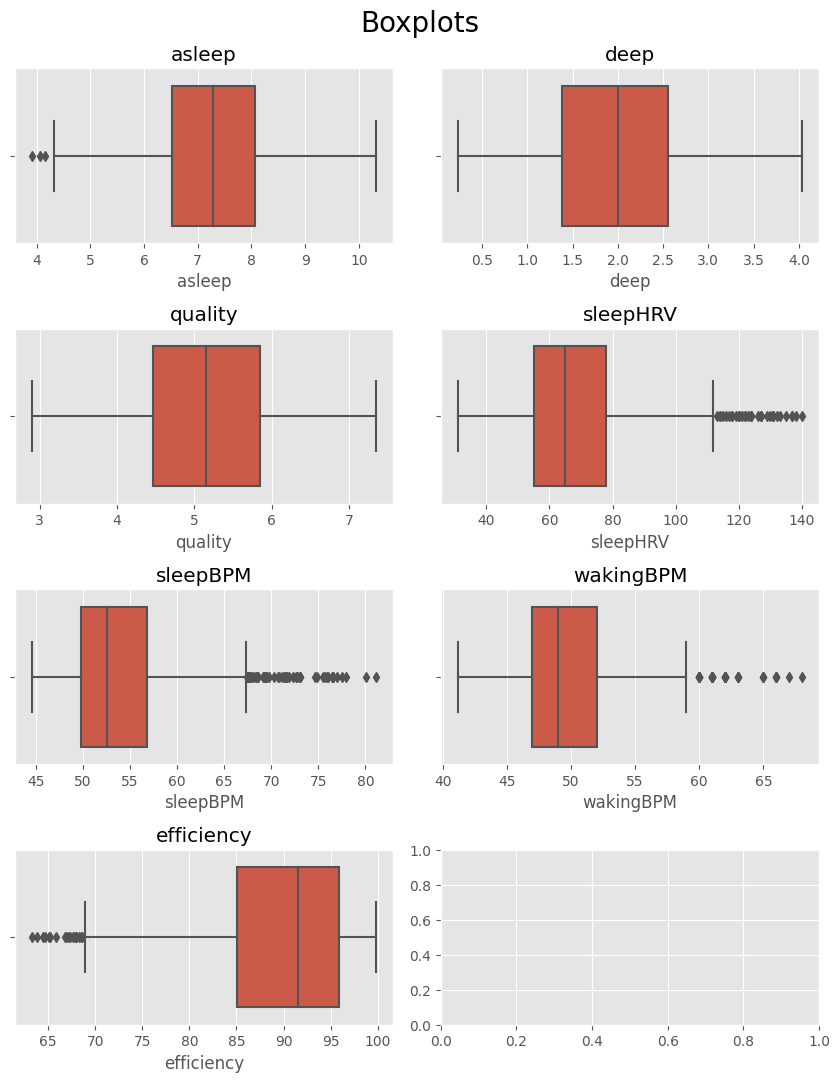

1006
1395


<Figure size 640x480 with 0 Axes>

In [15]:
# Remove top and bottom 3 outlier rows for each column
df_box = df[['asleep', 'deep', 'quality', 'sleepHRV', 'sleepBPM', 'wakingBPM', 'efficiency']]
for col in df_box.columns:
    df_box = df_box[(df_box[col] > df_box[col].quantile(0.01)) & (df_box[col] < df_box[col].quantile(0.99))]

# Boxplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8.5, 11))
plt.suptitle('Boxplots', size=20)
for i, col in enumerate(df_box.columns):
    sns.boxplot(x=col, data=df_box, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col}')
plt.tight_layout()
plt.show()

plt.savefig('boxplots.jpg', dpi=400)
print(len(df_box))
print(len(df))


/var/folders/y_/8cmvsg791ys9qqbzj_yxrlj40000gn/T/ipykernel_87223/2486680100.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)


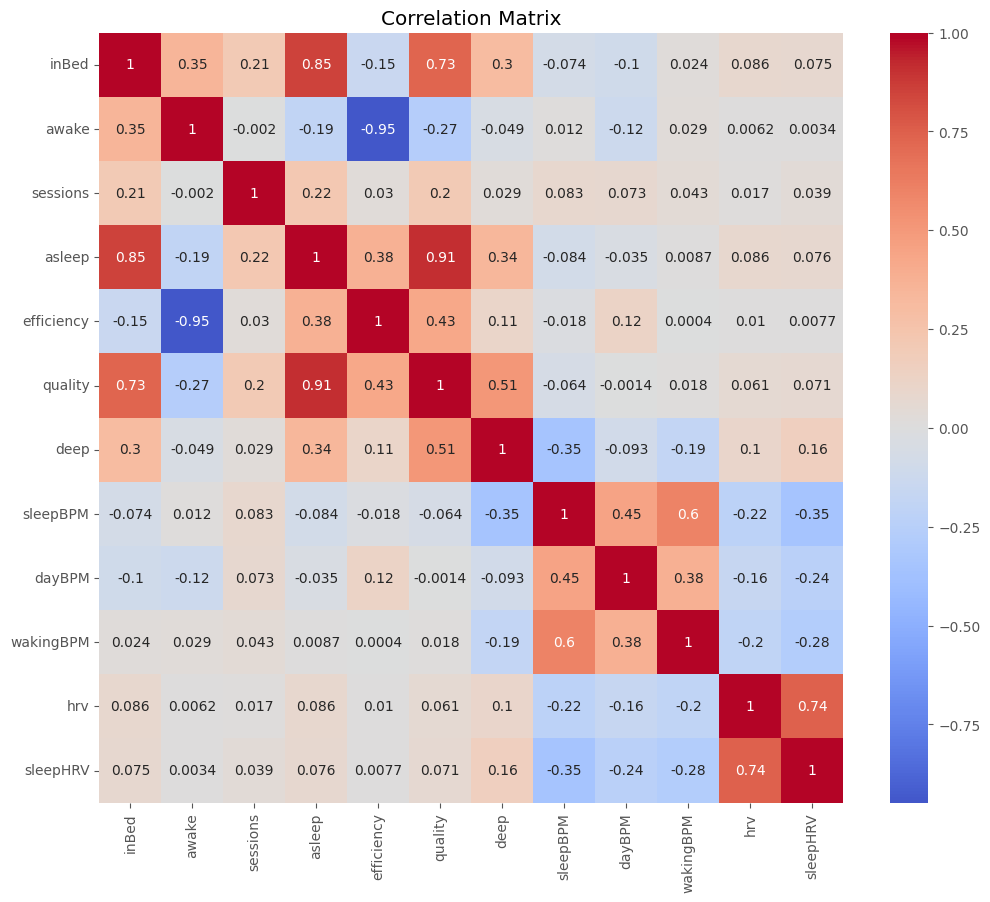

In [16]:
correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


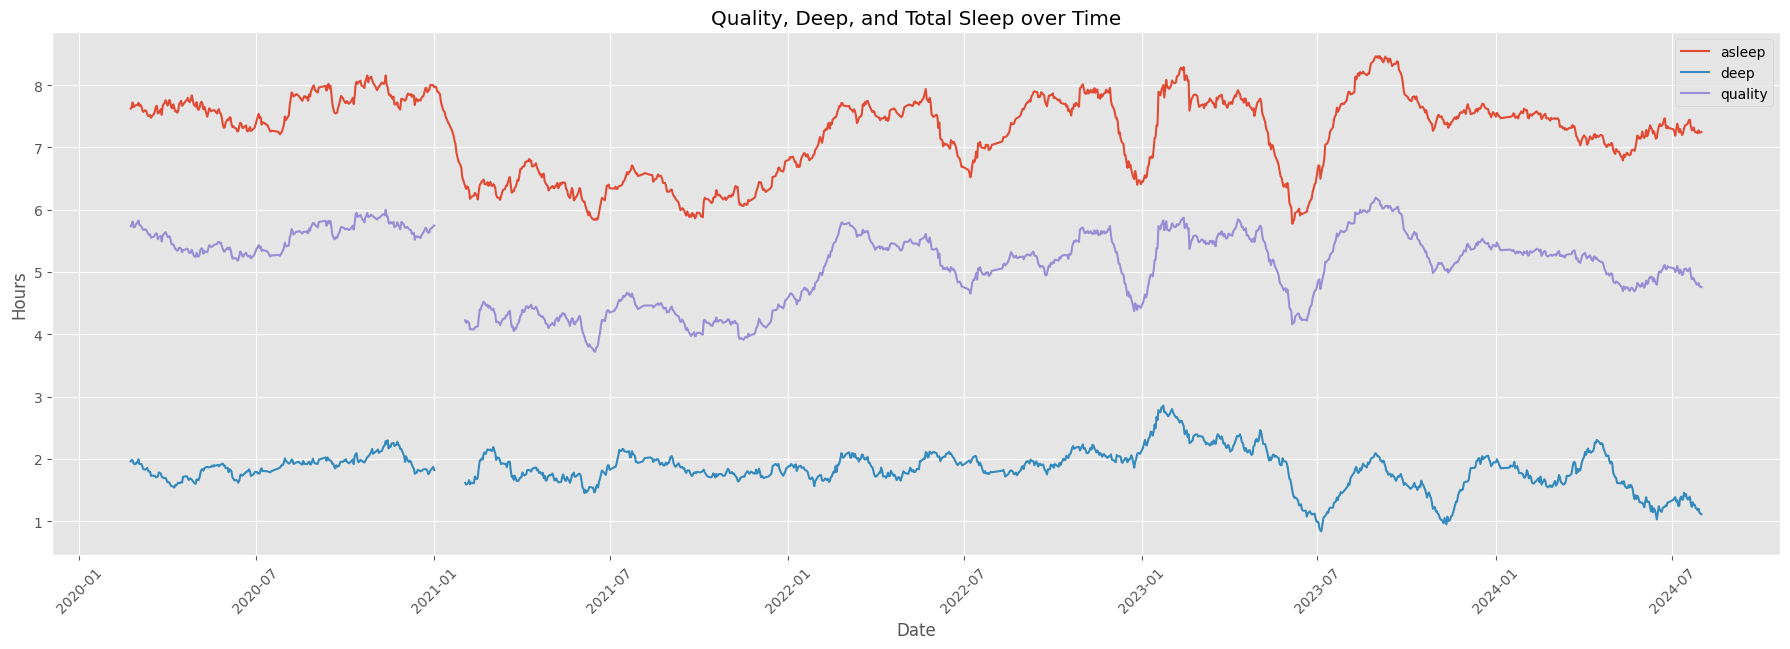

In [17]:
window = 30

fig, ax1 = plt.subplots(figsize=(18,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Hours')
ax1.plot(df['fromDate'], df['asleep'].rolling(window=window).mean(), label='asleep')
ax1.plot(df['fromDate'], df['deep'].rolling(window=window).mean(), label='deep')
ax1.plot(df['fromDate'], df['quality'].rolling(window=window).mean(), label='quality')
ax1.tick_params(axis='y')
ax1.legend()

fig.tight_layout()  
plt.title('Quality, Deep, and Total Sleep over Time')
plt.xticks(rotation=45)
plt.show()


In [18]:
def med(col, rnd=None):
    return round(df[col].median(), rnd)

def avg(col, rnd=None):
    return round(df[col].mean(), rnd)
from statistics import mode

def mod(col, rnd=None):
    mode_val = mode(df[col])
    mode_count = df[col].tolist().count(mode_val)
    return f"{round(mode_val, rnd)} (count = {mode_count})"


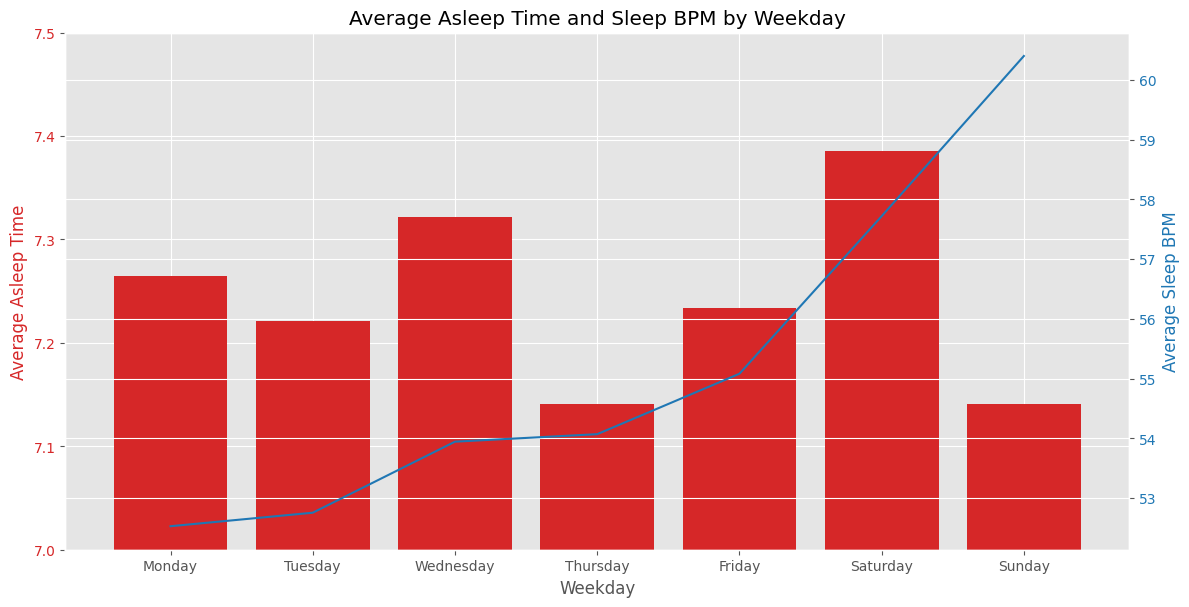

In [19]:
df['weekday'] = df['fromDate'].dt.day_name()
df['weekday'] = pd.Categorical(df['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['asleep'] = df['asleep'].astype(float)
df['sleepBPM'] = df['sleepBPM'].astype(float)

df_weekday = df.groupby('weekday').agg({'asleep': 'mean', 'sleepBPM': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Average Asleep Time', color=color)
ax1.bar(df_weekday['weekday'], df_weekday['asleep'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(7, 7.5)  # Set the y-axis limits to only show between 6 and 8

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Average Sleep BPM', color=color)  
ax2.plot(df_weekday['weekday'], df_weekday['sleepBPM'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Average Asleep Time and Sleep BPM by Weekday')
plt.xticks(rotation=45)
plt.show()


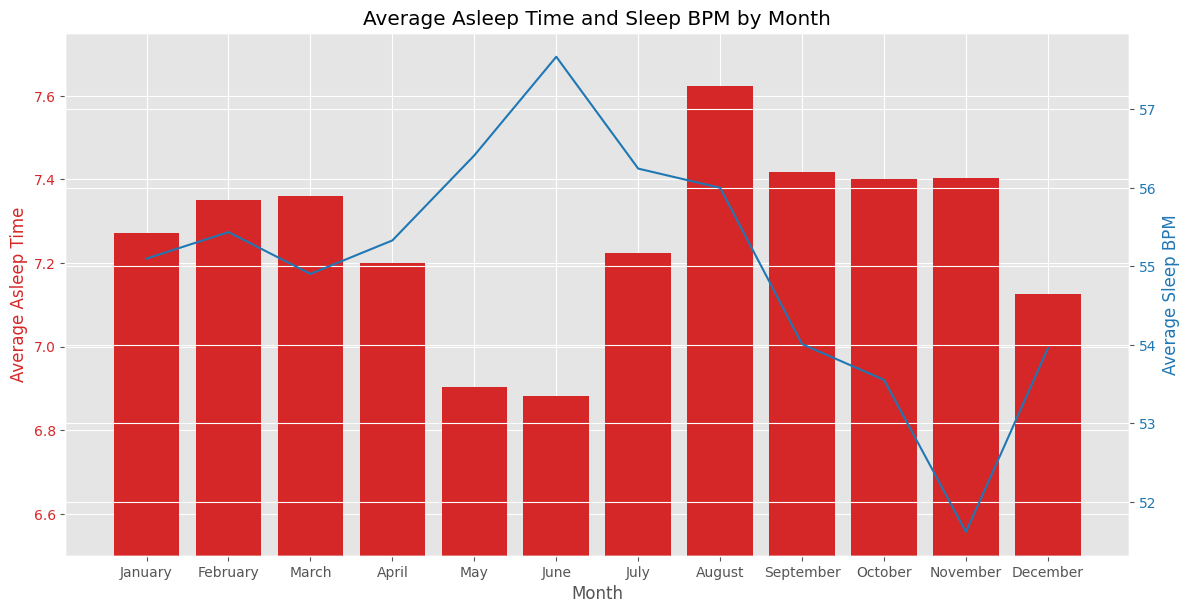

In [20]:
df['month'] = df['fromDate'].dt.month_name()
df['month'] = pd.Categorical(df['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df['asleep'] = df['asleep'].astype(float)
df['sleepBPM'] = df['sleepBPM'].astype(float)

df_month = df.groupby('month').agg({'asleep': 'mean', 'sleepBPM': 'mean'}).reset_index()
df_month['datapoints'] = df.groupby('month').size().values
for i, v in enumerate(df_month['datapoints']):
    ax1.text(i, v + 6.5, f'n={v}', ha='center', va='bottom', color='black', rotation=90)

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Asleep Time', color=color)
ax1.bar(df_month['month'], df_month['asleep'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(6.5, 7.75)  # Set the y-axis limits to only show between 6 and 8

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Average Sleep BPM', color=color)  
ax2.plot(df_month['month'], df_month['sleepBPM'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Average Asleep Time and Sleep BPM by Month')
plt.xticks(rotation=45)
plt.show()

In [21]:
df_month

,month,asleep,sleepBPM,datapoints
0,January,7.270982,55.098198,112
1,February,7.350667,55.435200,125
2,March,7.359926,54.902941,136
3,April,7.200243,55.329197,137
4,May,6.902676,56.411679,137
5,June,6.881667,57.666923,130
6,July,7.223056,56.243333,120
7,August,7.622348,55.998864,88
8,September,7.418537,54.009184,98
9,October,7.400833,53.554000,100


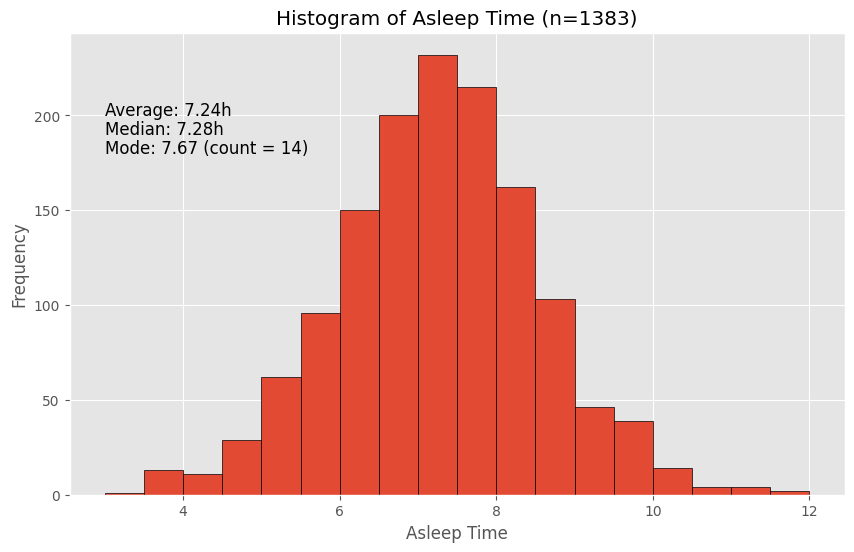

[ 3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12. ]


In [22]:
plt.figure(figsize=(10,6))
histlen = len(df[(df["asleep"] >= 3) & (df["asleep"] <= 12)])
diff = (12-3)*2
n, bins, patches = plt.hist(df['asleep'], bins=diff, edgecolor='black', range=(3, 12))
plt.text(3, 200, f'Average: {avg("asleep", 2)}h', fontsize=12, ha='left')
plt.text(3, 190, f'Median: {med("asleep", 2)}h', fontsize=12, ha='left')
plt.text(3, 180, f'Mode: {mod("asleep", 2)}', fontsize=12, ha='left')
plt.title(f'Histogram of Asleep Time (n={histlen})')
plt.xlabel('Asleep Time')
plt.ylabel('Frequency')
plt.show()

# Now you can print the values of the bins
print(bins)

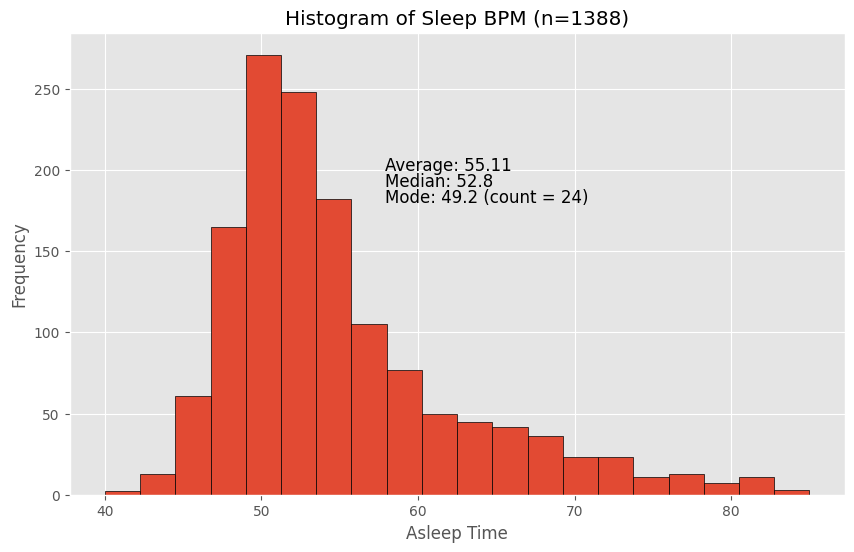

[40.   42.25 44.5  46.75 49.   51.25 53.5  55.75 58.   60.25 62.5  64.75
 67.   69.25 71.5  73.75 76.   78.25 80.5  82.75 85.  ]


In [23]:
df_sleepBPM = df[(df['sleepBPM'] >= 40) & (df['sleepBPM'] <= 85)]


plt.figure(figsize=(10,6))

histlenbpm = len(df_sleepBPM)
# diff = (12-3)*2
t75 = df['sleepBPM'].quantile(0.75)



n, bins, patches = plt.hist(df_sleepBPM['sleepBPM'], bins=20, edgecolor='black', range=(40,85))
plt.text(t75, 200, f'Average: {avg("sleepBPM", 2)}', fontsize=12, ha='left')
plt.text(t75, 190, f'Median: {med("sleepBPM", 2)}', fontsize=12, ha='left')
plt.text(t75, 180, f'Mode: {mod("sleepBPM", 2)}', fontsize=12, ha='left')


plt.title(f'Histogram of Sleep BPM (n={histlenbpm})')
plt.xlabel('Asleep Time')
plt.ylabel('Frequency')
plt.show()

# Now you can print the values of the bins
print(bins)

In [24]:
def med(col, rnd=None):
    return round(df[col].median(), rnd)

def avg(col, rnd=None):
    return round(df[col].mean(), rnd)
from statistics import mode

def mod(col, rnd=None):
    mode_val = mode(df[col])
    mode_count = df[col].tolist().count(mode_val)
    return f"{round(mode_val, rnd)} (count = {mode_count})"


In [25]:
print(f"Average Sleep: {avg('asleep', 2)}h")
print(f"Median Sleep: {med('asleep', 2)}h")
print(f"Mode Sleep: {mod('asleep', 2)}h")
print("----------------------------------------")
print(f"Average Quality Sleep: {avg('quality', 2)}h")
print(f"Median Quality Sleep: {med('quality', 2)}h")
print(f"Mode Quality Sleep: {mod('quality', 2)}h")
print("----------------------------------------")
print(f"Average Deep Sleep: {avg('deep', 2)}h")
print(f"Median Deep Sleep: {med('deep', 2)}h")
print(f"Mode Deep Sleep: {mod('deep', 2)}h")
print("----------------------------------------")
print(f"Average Sleep BPM: {avg('sleepBPM', 2)}")
print(f"Median Sleep BPM: {med('sleepBPM', 2)}")
print(f"Mode Sleep BPM: {mod('sleepBPM', 2)}")
print("----------------------------------------")
print(f"Average Waking BPM: {avg('wakingBPM', 2)}")
print(f"Median Waking BPM: {med('wakingBPM', 2)}")
print(f"Mode Waking BPM: {mod('wakingBPM', 2)}")

Average Sleep: 7.24h
Median Sleep: 7.28h
Mode Sleep: 7.67 (count = 14)h
----------------------------------------
Average Quality Sleep: 5.11h
Median Quality Sleep: 5.13h
Mode Quality Sleep: 5.55 (count = 17)h
----------------------------------------
Average Deep Sleep: 1.83h
Median Deep Sleep: 1.87h
Mode Deep Sleep: 0.0 (count = 105)h
----------------------------------------
Average Sleep BPM: 55.11
Median Sleep BPM: 52.8
Mode Sleep BPM: 49.2 (count = 24)
----------------------------------------
Average Waking BPM: 50.55
Median Waking BPM: 49.0
Mode Waking BPM: 49.0 (count = 146)
